In [7]:
import glob
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Camera calibration

CameraCalibration class handles all methods related to camera calibration.
If the constructor is called with the path of calibration image files, a new calibration process will be executed. Camera matrix and distortion coefficients will be stored in a dump. Later if the constructor is called without the path, the formerly generated camera parameters will be loaded from the dump.
If you want to make an indistortion on an image you can call the `undistort` method.

In [1]:
class CameraCalibration:
    def __init__(self, nCols = 9, nRows = 6, calibrationFiles = None):
        """Creates a camera calibration object

        nCols - Number of columns
        nRows - Number of rows
        calibrationFiles - Files calibration based on. If None camera parameters will be loaded from a pickle binary.
        """
        self._nRows = nRows
        self._nCols = nCols
        self._pickleFilename = 'camera_parameters.p'
        if calibrationFiles != None:
            self._cameraMatrix, self._distCoeffs = self._calibrate(calibrationFiles)
        else:
            cameraParams = pickle.load(open(self._pickleFilename, 'rb'))
            self._cameraMatrix = cameraParams['cameraMatrix']
            self._distCoeffs = cameraParams['distCoeffs']

    def _calibrate(self, path):
        """Calibrates the camera

        path - Files of image calibration based on.
        
        Returns camera matrix and distortion coefficients
        """
        coordinates = np.zeros((self._nRows * self._nCols, 3), np.float32)
        coordinates[:, :2] = np.mgrid[0 : self._nCols, 0 : self._nRows].T.reshape(self._nCols * self._nRows, 2)
        objectPoints = []
        imagePoints = []
        calibrationFiles = glob.glob(path)
        for idx, filename in enumerate(calibrationFiles):
            colorImage = cv2.imread(filename) # in BGR
            grayscaleImage = cv2.cvtColor(colorImage, cv2.COLOR_BGR2GRAY)
            retVal, corners = cv2.findChessboardCorners(grayscaleImage, (self._nCols, self._nRows))
            if retVal: # it is not sure all chessboard corners are found
                objectPoints.append(coordinates)
                imagePoints.append(corners)
        retVal, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, (1280, 720), None, None)
        pickle.dump({'cameraMatrix': cameraMatrix, 'distCoeffs': distCoeffs}, open(self._pickleFilename, 'wb'))
        return cameraMatrix, distCoeffs

    def undistort(self, image):
        """Undistort an image

        image - Image what will be undistorted
        
        Returns the undistorted image
        """
        return cv2.undistort(image, self._cameraMatrix, self._distCoeffs)

First time the camera must be calibrated using the calibration images.

In [2]:
camera = CameraCalibration(9,6,'camera_cal/calibration*.jpg')

Helper function to show two images

In [14]:
def plotImages(image1, title1, image2, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title(title1)
    ax1.imshow(image1)
    ax2.set_title(title2)
    ax2.imshow(image2)

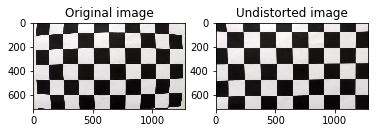

In [15]:
image1 = plt.imread('camera_cal/calibration1.jpg')
image2 = camera.undistort(image1)
plotImages(image1, 'Original image', image2, 'Undistorted image')